<a href="https://colab.research.google.com/github/Prags21/SentimentAnalysis/blob/master/HashtagsGraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:

from tqdm import tqdm
%matplotlib inline
#Module to handle regular expressions
import re
#manage files

import os
#Library for emoji
#import emoji
#Import pandas and numpy to handle data
import pandas as pd
import numpy as np

#import libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from PIL import Image

#Import nltk to check english lexicon
import nltk
from nltk.tokenize import word_tokenize

from nltk.corpus import (
    wordnet,
    stopwords
)

#import libraries for tokenization and ML
import json;
import keras;
import keras.preprocessing.text as kpt;
#from keras.preprocessing.text import Tokenizer;

import sklearn
from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import (
    CountVectorizer,
    TfidfVectorizer
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from textblob import TextBlob
from textblob import Word

#Import all libraries for creating a deep neural network
#Sequential is the standard type of neural network with stackable layers
from keras.models import (
    Sequential,
    model_from_json
)
#Dense: Standard layers with every node connected, dropout: avoids overfitting
from keras.layers import Dense, Dropout, Activation;
table=pd.read_csv('RawResult.csv',delimiter = ',',encoding = "utf-8")
stop = stopwords.words('english')


In [41]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [0]:
#preprocess text in tweets by removing links, @UserNames, blank spaces, etc.
def preprocessing_text(table):
    #put everythin in lowercase
    table['Tweet Text'] = table['Tweet Text'].str.lower()
    #Replace rt indicating that was a retweet
    #table['Tweet Text'] = table['Tweet Text'].str.replace('rt', '')
    table['Tweet Text'] = table['Tweet Text'].str.replace('[^\w\s]','')
    #Replace occurences of mentioning @UserNames
    table['Tweet Text'] = table['Tweet Text'].replace(r'@\w+', '', regex=True)
    #Replace links contained in the tweet
    table['Tweet Text'] = table['Tweet Text'].replace(r'http\S+', '', regex=True)
    table['Tweet Text'] = table['Tweet Text'].replace(r'www.[^ ]+', '', regex=True)
    #remove numbers
    table['Tweet Text'] = table['Tweet Text'].replace(r'[0-9]+', '', regex=True)
    #replace special characters and puntuation marks
    table['Tweet Text'] = table['Tweet Text'].replace(r'[!"#$%&()*+,-./:;<=>?@[\]^_`{|}~]', '', regex=True)
    #table['Tweet Text'] = table['Tweet Text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
    #freq = pd.Series(' '.join(table['Tweet Text']).split()).value_counts()[:10]
    #freq = list(freq.index)
    #table['Tweet Text'] = table['Tweet Text'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
    #freq = pd.Series(' '.join(table['Tweet Text']).split()).value_counts()[-10:]
    #freq = list(freq.index)
    #table['Tweet Text'] = table['Tweet Text'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
    #table['Tweet Text']=table['Tweet Text'].apply(lambda x: str(TextBlob(x).correct()))

    return table

In [0]:
#table=preprocessing_text(table)  
#table['Tweet Text'] = table['Tweet Text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
#print(TextBlob(train['Tweet text'][0]).ngrams(2))


#print(TextBlob(table['Tweet Text'][1]).words)

In [0]:

#Replace elongated words by identifying those repeated characters and then remove them and compare the new word with the english lexicon
def in_dict(word):
    if wordnet.synsets(word):
        #if the word is in the dictionary, we'll return True
        return True

def replace_elongated_word(word):
    regex = r'(\w*)(\w+)\2(\w*)'
    repl = r'\1\2\3'    
    if in_dict(word):
        return word
    new_word = re.sub(regex, repl, word)
    if new_word != word:
        return replace_elongated_word(new_word)
    else:
        return new_word

def detect_elongated_words(row):
    regexrep = r'(\w*)(\w+)(\2)(\w*)'
    words = [''.join(i) for i in re.findall(regexrep, row)]
    for word in words:
        if not in_dict(word):
            row = re.sub(word, replace_elongated_word(word), row)
    return row

In [0]:
def stop_words(table):
    #We need to remove the stop words
    stop_words_list = stopwords.words('english')
    table['Tweet Text'] = table['Tweet Text'].str.lower()
    table['Tweet Text'] = table['Tweet Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words_list)]))
    return table

In [0]:
def replace_antonyms(word):
    #We get all the lemma for the word
    for syn in wordnet.synsets(word): 
        for lemma in syn.lemmas(): 
            #if the lemma is an antonyms of the word
            if lemma.antonyms(): 
                #we return the antonym
                return lemma.antonyms()[0].name()
    return word
            
def handling_negation(row):
    #Tokenize the row
    words = word_tokenize(row)
    speach_tags = ['JJ', 'JJR', 'JJS', 'NN', 'VB', 'VBD', 'VBG', 'VBN', 'VBP']
    #We obtain the type of words that we have in the text, we use the pos_tag function
    tags = nltk.pos_tag(words)
    #Now we ask if we found a negation in the words
    tags_2 = ''
    if "n't" in words and "not" in words:
        tags_2 = tags[min(words.index("n't"), words.index("not")):]
        words_2 = words[min(words.index("n't"), words.index("not")):]
        words = words[:(min(words.index("n't"), words.index("not")))+1]
    elif "n't" in words:
        tags_2 = tags[words.index("n't"):]
        words_2 = words[words.index("n't"):] 
        words = words[:words.index("n't")+1]
    elif "not" in words:
        tags_2 = tags[words.index("not"):]
        words_2 = words[words.index("not"):]
        words = words[:words.index("not")+1] 
        
    for index, word_tag in enumerate(tags_2):
        if word_tag[1] in speach_tags:
            words = words+[replace_antonyms(word_tag[0])]+words_2[index+2:]
            break
            
    return ' '.join(words)

In [0]:
def cleaning_table(table):
    #This function will process all the required cleaning for the text in our tweets
    table = preprocessing_text(table)
    table['Tweet Text'] = table['Tweet Text'].apply(lambda x: detect_elongated_words(x))
    table['Tweet Text'] = table['Tweet Text'].apply(lambda x: handling_negation(x))
    table = stop_words(table)
    return table

In [0]:
#Vectorization for Data Visualization
def vectorization(table):
    #CountVectorizer will convert a collection of text documents to a matrix of token counts
    #Produces a sparse representation of the counts 
    #Initialize
    vector = CountVectorizer()
    #We fit and transform the vector created
    frequency_matrix = vector.fit_transform(table['Tweet Text'])
    #Sum all the frequencies for each word
    sum_frequencies = np.sum(frequency_matrix, axis=0)
    #Now we use squeeze to remove single-dimensional entries from the shape of an array that we got from applying np.asarray to
    #the sum of frequencies.
    frequency = np.squeeze(np.asarray(sum_frequencies))
    #Now we get into a dataframe all the frequencies and the words that they correspond to
    frequency_df = pd.DataFrame([frequency], columns=vector.get_feature_names())#.transpose()
    list_words=[]
    for name in frequency_df.columns:
      dict={}
      dict['name']=name
      dict['frequency']=frequency_df[name][0]
      list_words.append(dict);
    return list_words

In [0]:

def word_cloud(tweets):
    
    #We get the directory that we are working on
    file = os.getcwd()
    #We read the mask image into a numpy array
    #Now we store the tweets into a series to be able to process 
    #tweets_list = pd.Series([t for t in tweet_table.tweet]).str.cat(sep=' ')  
    #We generate the wordcloud using the series created and the mask 
    word_cloud = WordCloud(width=2000, height=1000, max_font_size=200, background_color="black", max_words=2000, contour_width=1, 
                           contour_color="steelblue", colormap="nipy_spectral", stopwords=["Automation"])
    word_cloud.generate(tweets)
    
    #wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(tweets_list)
    
    #Now we plot both figures, the wordcloud and the mask
    #plt.figure(figsize=(15,15))
    plt.figure(figsize=(10,10))
    plt.imshow(word_cloud, interpolation="hermite")
    plt.axis("off")
    #plt.imshow(avengers_mask, cmap=plt.cm.gray, interpolation="bilinear")
    #plt.axis("off")    
    plt.show()

In [0]:
def graph(word_frequency, sent):
    labels = word_frequency[0][1:51].index
    title = "Word Frequency for %s" %sent
    #Plot the figures
    plt.figure(figsize=(10,5))
    plt.bar(np.arange(50), word_frequency[0][1:51], width = 0.8, color = sns.color_palette("bwr"), alpha=0.5, 
            edgecolor = "black", capsize=8, linewidth=1);
    plt.xticks(np.arange(50), labels, rotation=90, size=14);
    plt.xlabel("50 more frequent words", size=14);
    plt.ylabel("Frequency", size=14);
    #plt.title('Word Frequency for %s', size=18) %sent;
    plt.title(title, size=18)
    plt.grid(False);
    plt.gca().spines["top"].set_visible(False);
    plt.gca().spines["right"].set_visible(False);
    plt.show()

[{'name': 'ai', 'frequency': 150}, {'name': 'intelligence', 'frequency': 150}, {'name': 'artificial', 'frequency': 140}, {'name': 'brt', 'frequency': 82}, {'name': 'artificialinteligence', 'frequency': 68}, {'name': 'xexacxefxbxf', 'frequency': 60}, {'name': 'machinelearning', 'frequency': 50}, {'name': 'robotics', 'frequency': 50}, {'name': 'new', 'frequency': 46}, {'name': 'deplearning', 'frequency': 36}]
[('Artificial', 'ai'), ('Intelligence', 'ai'), ('Business', 'ai'), ('AI', 'ai'), ('Fraud', 'ai'), ('Artificial', 'intelligence'), ('Intelligence', 'intelligence'), ('Business', 'intelligence'), ('AI', 'intelligence'), ('Fraud', 'intelligence'), ('Artificial', 'artificial'), ('Intelligence', 'artificial'), ('Business', 'artificial'), ('AI', 'artificial'), ('Fraud', 'artificial'), ('Artificial', 'ai'), ('Intelligence', 'ai'), ('AI', 'ai'), ('ArtificialIntelligence', 'ai'), ('Toronto', 'ai'), ('Business', 'ai'), ('Artificial', 'intelligence'), ('Intelligence', 'intelligence'), ('AI', '

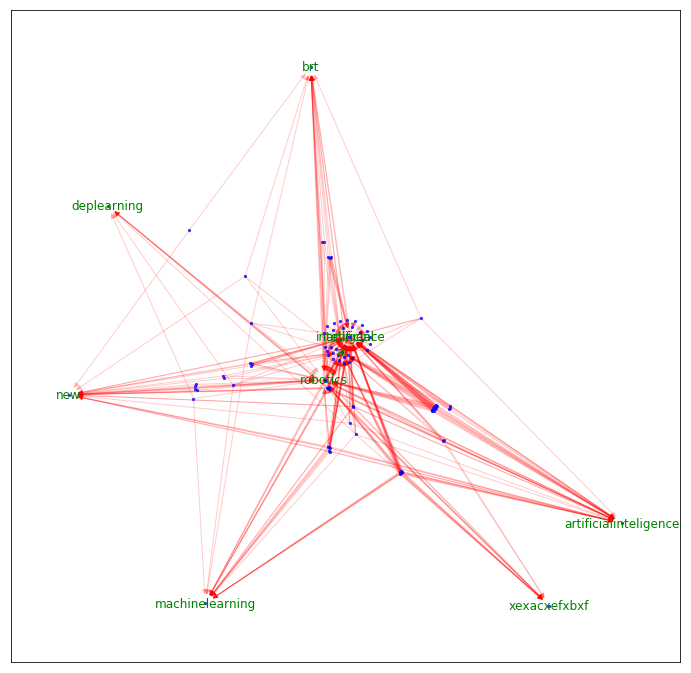

In [72]:
from collections import Counter
import matplotlib.pyplot as plt
import networkx as nx

table=cleaning_table(table)  

word_frequency = vectorization(table)
edges_=[]
labels={}
G = nx.DiGraph()
word_f = sorted(word_frequency, key=lambda d: d['frequency'], reverse=True)[0:10]
print(word_f)
for ind,item in table.iterrows():
    for wrd in word_f:
      if wrd['name'] in item['Tweet Text']:  
        if isinstance(item['Hashtags'],str):
          hashtagsList = item['Hashtags'].split()
          for hashtag in hashtagsList:
            edges_.append((hashtag,wrd['name']))
          labels[wrd['name']]=wrd['name']
  #graph(word_frequency, 'all')

  #word_cloud(pd.Series([t for t in table['Tweet Text']]).str.cat(sep=' ')) 
print(edges_)
G.add_edges_from(edges_,weight=1)
  
pos = nx.spring_layout(G)
plt.figure(figsize=(12,12))
_=nx.draw_networkx_nodes(G, pos, node_size=5,node_color='b',alpha = 0.7)
_=nx.draw_networkx_edges(G, pos ,alpha=0.2,edge_color='r' )
_=nx.draw_networkx_labels(G,pos,labels,font_size=12,font_color='g')  


In [0]:

# pylint: skip-file
import matplotlib
import re
import numpy
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import warnings
from collections import *
from itertools import count

from random import randint
warnings.filterwarnings("ignore")
class OrderedCounter(Counter, OrderedDict):
    pass
listOfTweets=[]
d =[]
G = nx.DiGraph()
def get_rt_sources(tweet):
    rt_patterns = re.compile(r"(RT|via)((?:\b\W*@\w+)+)", re.IGNORECASE)
    return [ source.strip()
             for tuple in rt_patterns.findall(tweet)
                 for source in tuple
                     if source not in ("RT", "via") ]
for tweet in table.iterrows():
    t=str(tweet[1]['Tweet Text'])
    rt_sources = get_rt_sources(t)
    if not rt_sources: continue
    for rt_source in rt_sources:
        l_rt=[]
        if ":" in rt_source:
            d=re.split(r'@(\w+)' ,rt_source)
            for rt in d:
                if (rt.isalnum() or '_' in rt):
                    G.add_edges_from([(tweet[1]['Screen Name'],"@"+rt)], weight=tweet[1]['Retweet Count'])
                    listOfTweets.append("@"+rt)
        else :
            G.add_edges_from([(tweet[1]['Screen Name'],rt_source)], weight=tweet[1]['Retweet Count'])
            listOfTweets.append(rt_source)
counts=Counter(listOfTweets).most_common(30)
a=[]
size_n=[]
labels = {}
n_color=[]
for i in counts:
    d={}
    d['node_']=i[0]
    d['frequency']=i[1]
    a.append(d)
for node in G.nodes():
    size_n.append(5)
    n_color.append('blue')
for node in G.nodes():
    for idx, item in enumerate(a):
        if node in item['node_']:
            size_n[idx] = round(item['frequency']/10)
            n_color[idx] = 'red'
            labels[item['node_']] = item['node_']

pos = nx.spring_layout(G)
plt.figure(figsize=(12,12))
_=nx.draw_networkx_nodes(G, pos, node_size=size_n,node_color=n_color,alpha = 0.7)
_=nx.draw_networkx_edges(G, pos ,alpha=0.2,edge_color='r' )
_=nx.draw_networkx_labels(G,pos,labels,font_size=12,font_color='g')